# Реализация табличного Q-Learning

В этом уроке мы разберем на практике простой алгоритм обучения табличной Q-функции на примере задачи Frozen Lake.

### Загрузка библиотек

In [1]:
import numpy as np

import gym

import matplotlib.pyplot as plt
%matplotlib inline

### Создание игровой среды
Создадим симулятор Frozen Lake.

In [2]:
env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="ansi")

NUM_STATES = env.observation_space.n
NUM_ACTIONS = env.action_space.n

print('States: {}'.format(NUM_STATES))
print('Actions: {}'.format(NUM_ACTIONS))

States: 16
Actions: 4


### Параметры обучения

* `lr` - скорость обучения (в теории это был параметр `alpha`)
* `gamma` - параметр дисконтирования
* `NUM_EPISODES` - сколько всего эпизодов игры будем осуществлять
* `MAX_STEPS` - максимальное количесвто шагов в рамках одного эпизода. Эпизод может закончиться и раньше. Это ограничение нужно, если агент зашёл в какой-то тупик и там застрял. Или для бесконечных игр/симуляций.

In [3]:
lr = 0.8 # learning rate
gamma = 0.95 # параметр дисконтирования

NUM_EPISODES = 50 # число эпизодов для обучения
MAX_STEPS = 100 # максимальное число шагов в эпизоде

### Обучение Q-функции

Во время обучения удобно следить за разными характеристиками. В данном случае будем собирать данные о длине траектории (как далеко удаётся дойти нашему агенту) по эпизодам и суммарную награду по эпизодам. От эпизода к эпизоду наш агент должен становиться всё лучше и лучше.

Создаём Q-функцию (таблицу) и инициализируем её случайными числами. В нашем простом Q-Learning'е во время игры мы всегда будем использовать детерминированную политику (выбор действия строго по Q-функции). Поэтому важно инициализировать Q-функцию так, чтобы агент не застревал в циклах и всё же мог когди-нибудь дойти до цели. В нашем случае, главное -- не занулять те значения Q-функции, которые потенциально могут привести нас к цели (например, нельзя всю таблицу инициализировать нулями). У такой проблемы есть и более элегантное решение, которое мы рассмотрим в других уроках.

Далее идёт цикл по эпизодам и цикл по шагам внутри эпизода.

В начале каждого эпизода переходим на нулевое состояние `env.reset()`

Один шаг обучения состоит в следующем:

* Выбор действия `a` по политике с использованием текущей функции Q
* Сообщение действия среде, получение следующего состояния `s1`, награды `r` и сигнала о конце эпизода `done`.
* Вычисление целевого (нового) значения `Q_target` (по уравнению Беллмана)
* Плавное обновление Q функции для старого состояния `s` и действия `a` (с использование learning rate)

В конце каждого эпизода смотрим на суммарную накопленную награду.

In [11]:
pathLenList = [] # длины траекторий по эпизодам
totalRewardList = [] # суммарные награды по эпизодам

# Инициализация Q-функции (таблицы)
Q = np.random.rand(NUM_STATES, NUM_ACTIONS)

for i in range(NUM_EPISODES):

    s = env.reset()[0]

    totalReward = 0
    step = 0

    while step < MAX_STEPS:
        step += 1

        # Выбор действия по текущей политике
        a = np.argmax(Q[s,...])

        # Сделать шаг
        s1, r, done, trunc, _ = env.step(a)

        # Новое (целевое) значение Q-функции
        if done:
            Q_target = r
        else:
            Q_target = r + gamma * np.max(Q[s1,...])

        # Обновление Q-функции
        Q[s,a] = (1-lr) * Q[s,a] + lr * Q_target

        totalReward += r
        s = s1

        # Если конец эпизода
        if done:
            break

    pathLenList.append(step)
    totalRewardList.append(totalReward)
    print('Episode {}: Total reward = {}'.format(i, totalReward))

Episode 0: Total reward = 0.0
Episode 1: Total reward = 0.0
Episode 2: Total reward = 0.0
Episode 3: Total reward = 1.0
Episode 4: Total reward = 0.0
Episode 5: Total reward = 1.0
Episode 6: Total reward = 1.0
Episode 7: Total reward = 1.0
Episode 8: Total reward = 1.0
Episode 9: Total reward = 1.0
Episode 10: Total reward = 1.0
Episode 11: Total reward = 1.0
Episode 12: Total reward = 1.0
Episode 13: Total reward = 1.0
Episode 14: Total reward = 1.0
Episode 15: Total reward = 1.0
Episode 16: Total reward = 1.0
Episode 17: Total reward = 1.0
Episode 18: Total reward = 1.0
Episode 19: Total reward = 1.0
Episode 20: Total reward = 1.0
Episode 21: Total reward = 1.0
Episode 22: Total reward = 1.0
Episode 23: Total reward = 1.0
Episode 24: Total reward = 1.0
Episode 25: Total reward = 1.0
Episode 26: Total reward = 1.0
Episode 27: Total reward = 1.0
Episode 28: Total reward = 1.0
Episode 29: Total reward = 1.0
Episode 30: Total reward = 1.0
Episode 31: Total reward = 1.0
Episode 32: Total 

/mnt/500_gb/data_science/.venv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Посмотрим на то, как выглядит обученная оптимальная Q-функция

In [12]:
print(Q)

[[0.38438592 0.77378094 0.38440267 0.3969691 ]
 [0.38438662 0.10075075 0.38631703 0.26157339]
 [0.38225727 0.09821301 0.33186942 0.38631703]
 [0.19359335 0.45490818 0.60842016 0.08575624]
 [0.2159014  0.81450625 0.13905218 0.52949517]
 [0.38748215 0.93851886 0.82057687 0.66013801]
 [0.27473864 0.44712767 0.38915651 0.34470564]
 [0.95506289 0.69490268 0.91605076 0.91341524]
 [0.24337498 0.1779522  0.857375   0.30335775]
 [0.21532758 0.9025     0.44083967 0.18372542]
 [0.27502894 0.62195666 0.32102945 0.18673937]
 [0.439581   0.21788279 0.05233391 0.06020814]
 [0.89834505 0.47644115 0.17020213 0.57587063]
 [0.69685811 0.59187474 0.95       0.79882612]
 [0.17317982 0.60341057 1.         0.47926816]
 [0.02740855 0.699805   0.58590369 0.82684718]]


Посмотрим на историю длин траекторий. Видно, что сначала агент долго гулял и не мог найти цель (на ранних эпизодах). Потом постепенно он научился находить цель за минимальное количество шагов.

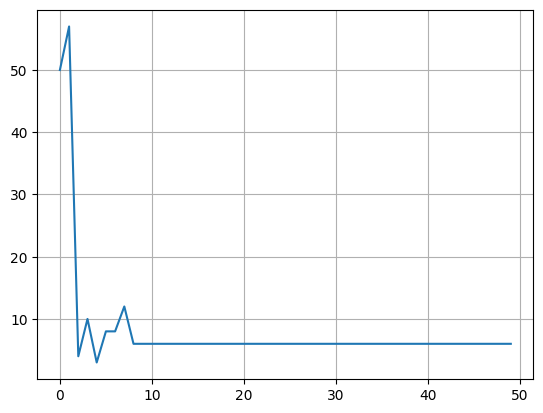

In [13]:
plt.plot(pathLenList)
plt.grid()

То же самое видно на графике суммарных наград по эпизодам. На ранних эпизодах награда 0 (это значит, что агент либо падал в яму, либо так и не смог завершить эпизод за `MAX_STEPS` шагов). А далее награда 1, то есть агент стал доходить до цели.

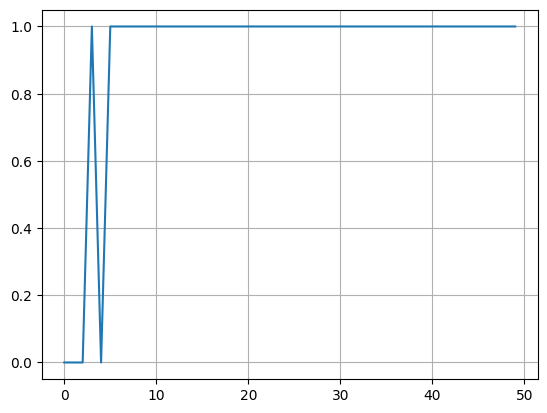

In [14]:
plt.plot(totalRewardList)
plt.grid()

### Запуск симуляции

Запустим симуляцию для Frozen Lake так же, как мы делали до этого. Будем использовать стратегию, основанную на обученной оптимальной Q-функции.

In [17]:
totalReward = 0
s = env.reset()[0]

for _ in range(100):
    print(env.render())
    a = np.argmax(Q[s,:]) # выбираем оптимальное действие
    s, r, done, trunc, _ = env.step(a)
    totalReward += r
    if done:
        print(env.render())
        break

env.close()
print('Total reward = {}'.format(totalReward))


SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

Total reward = 1.0
